In [1]:
from copy import deepcopy

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import MNIST

In [2]:
def encoder_net(layer_sizes):
    layers = []
    for i, _ in enumerate(layer_sizes[:-1]):
        layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
        layers.append(nn.Sigmoid())
    net = nn.Sequential(
        nn.Flatten(),
        *layers,
    )
    for parameter in net.parameters():
        parameter.requires_grad_(False)
    return net

def classifier_net(hidden_size):
    return nn.Sequential(
        nn.Linear(hidden_size, 10),
        nn.Softmax(-1),
    )


class HebbianNet(nn.Module):
    def __init__(self, layer_sizes):
        if not layer_sizes:
            raise ValueError(f'layer_sizes {layer_sizes} in HebbianNet must not be empty')
        super(HebbianNet, self).__init__()
        self.layer_sizes = layer_sizes
        self.encoder = encoder_net(layer_sizes)
        self.reset_classifier()
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.classifier(x)
        return x
    
    def reset_classifier(self):
        self.classifier = classifier_net(self.layer_sizes[-1])
    
    def train_classifier(self, train_loader, valid_loader,
                         nb_epochs=200, patience=5, tol=1e-3, lr=1e-3, device=None, verbose=False):
        self.reset_classifier()
        if not device:
            device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self = self.to(device)
        criterion = nn.CrossEntropyLoss()
        optim = torch.optim.Adam(self.parameters(), lr=lr)
        min_valid_loss, final_valid_acc, epochs_no_improve = float('inf'), 0, 0
        best_model = deepcopy(self.state_dict())
        for epoch in range(nb_epochs):
            # Train loop
            train_loss = 0.
            train_acc = 0
            for batch in train_loader:
                images = batch[0].to(device)
                labels = batch[1].to(device)
                preds = self(images)
                loss = criterion(preds, labels)
                optim.zero_grad()
                loss.backward()
                optim.step()
                train_loss += loss.item()
                train_acc += torch.sum(torch.argmax(preds, -1) == labels).item()
            train_loss /= len(train_loader.dataset) 
            train_acc /= len(train_loader.dataset) 
            # Valid loop
            valid_loss = 0.
            valid_acc = 0
            for batch in valid_loader:
                images = batch[0].to(device)
                labels = batch[1].to(device)
                with torch.no_grad():
                    preds = self(images)
                loss = criterion(preds, labels)
                valid_loss += loss.item()
                valid_acc += torch.sum(torch.argmax(preds, -1) == labels).item()
            valid_loss /= len(valid_loader.dataset)
            valid_acc /= len(valid_loader.dataset)
            if verbose:
                print(f'[Epoch {epoch+1:2d}]  train_loss: {train_loss:.4f}'\
                      f'  train_acc: {train_acc:.3f}  valid_loss: {valid_loss:.4f}'\
                      f'  valid_acc: {valid_acc:.3f}')
            if valid_loss*(1+tol) < min_valid_loss:
                # Saving the model
                best_model = deepcopy(self.state_dict())
                min_valid_loss = valid_loss
                final_valid_acc = valid_acc
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
            # Check early stopping condition
            if epochs_no_improve == patience:
                break
        self.load_state_dict(best_model)
        return final_valid_acc

In [3]:
hebbian_net = HebbianNet([28*28, 500])

In [4]:
print('HebbianNet parameters: {}'.format(
    sum([torch.numel(p) for p in hebbian_net.parameters()])))
print('Encoder parameters:    {}'.format(
    sum([torch.numel(p) for p in hebbian_net.encoder.parameters()])))
print('Classifier parameters: {}'.format(
    sum([torch.numel(p) for p in hebbian_net.classifier.parameters()])))

HebbianNet parameters: 397510
Encoder parameters:    392500
Classifier parameters: 5010


In [5]:
batch_size = 32

In [6]:
train_set = MNIST(root="./data", train=True, download=True, transform=transforms.ToTensor())
train_set, valid_set = random_split(train_set, [50000, 10000])
test_set = MNIST(root="./data", train=False, download=True, transform=transforms.ToTensor())

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [7]:
hebbian_net.train_classifier(
    train_loader, valid_loader, lr=1e-3, verbose=True)

[Epoch  1]  train_loss: 0.0701  train_acc: 0.274  valid_loss: 0.0682  valid_acc: 0.403
[Epoch  2]  train_loss: 0.0664  train_acc: 0.461  valid_loss: 0.0653  valid_acc: 0.460
[Epoch  3]  train_loss: 0.0645  train_acc: 0.476  valid_loss: 0.0639  valid_acc: 0.481
[Epoch  4]  train_loss: 0.0635  train_acc: 0.481  valid_loss: 0.0632  valid_acc: 0.488
[Epoch  5]  train_loss: 0.0629  train_acc: 0.484  valid_loss: 0.0628  valid_acc: 0.487
[Epoch  6]  train_loss: 0.0625  train_acc: 0.492  valid_loss: 0.0622  valid_acc: 0.517
[Epoch  7]  train_loss: 0.0617  train_acc: 0.544  valid_loss: 0.0614  valid_acc: 0.586
[Epoch  8]  train_loss: 0.0607  train_acc: 0.595  valid_loss: 0.0602  valid_acc: 0.607
[Epoch  9]  train_loss: 0.0598  train_acc: 0.620  valid_loss: 0.0596  valid_acc: 0.632
[Epoch 10]  train_loss: 0.0593  train_acc: 0.628  valid_loss: 0.0591  valid_acc: 0.635
[Epoch 11]  train_loss: 0.0589  train_acc: 0.636  valid_loss: 0.0586  valid_acc: 0.700
[Epoch 12]  train_loss: 0.0580  train_acc: 

0.745

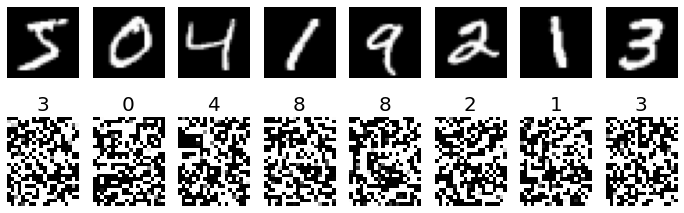

In [8]:
images = train_loader.dataset.dataset.data[:8]
embedds = hebbian_net.cpu().encoder(images.float())
preds = hebbian_net.cpu().classifier(embedds)
plt.figure(figsize=(12,4))
for i in range (8):
    plt.subplot(2, 8, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.axis('off')
    plt.subplot(2, 8, 8+i+1)
    plt.imshow(embedds[i].reshape(25, 20), cmap='gray')
    plt.axis('off')
    plt.title(torch.argmax(preds, -1)[i].item(), fontsize=20)


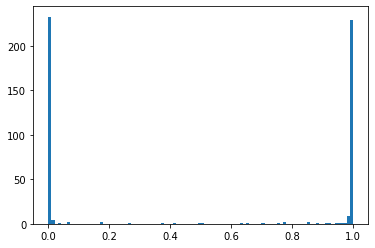

In [9]:
plt.hist(embedds[0].numpy(), bins=100);

# TODO: Hebbian training